In [ ]:
!pip3 install keras

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
batch_size = 32
num_classes = 10
epochs = 50

In [3]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range = 10,
    zoom_range = 0.2,
    horizontal_flip=True)

In [5]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(Activation('relu'))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [6]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
#model.add(Dropout(0.1))
model=CBGN(model,128)
#model.add(Dropout(0.1))
model=CBGN(model,256)
#model.add(Dropout(0.2))
model=CBGN(model,512)
#model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

In [7]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.05  
    elif epoch < 60:
        return 0.01  
    elif epoch < 75:
        return 0.001
    else:
        return 0.0001

set_lr = LRS(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Checkpoint Callback
checkpoint_cb = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/cifar/tmp/tmp_weights", save_best_only=True, save_weights_only=True, monitor='val_accuracy')

In [11]:
## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr,checkpoint_cb],
                            verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1562/1562 [==============================] - 48s 25ms/step - loss: 2.2356 - accuracy: 0.1824 - val_loss: 2.0323 - val_accuracy: 0.2910
Epoch 2/50
1562/1562 [==============================] - 39s 25ms/step - loss: 1.6708 - accuracy: 0.3608 - val_loss: 1.3670 - val_accuracy: 0.4936
Epoch 3/50
1562/1562 [==============================] - 39s 25ms/step - loss: 1.3852 - accuracy: 0.5003 - val_loss: 1.2444 - val_accuracy: 0.5528
Epoch 4/50
1562/1562 [==============================] - 39s 25ms/step - loss: 1.1650 - accuracy: 0.5952 - val_loss: 1.5727 - val_accuracy: 0.4833
Epoch 5/50
1562/1562 [==============================] - 38s 24ms/step - loss: 1.0002 - accuracy: 0.6520 - val_loss: 1.0213 - val_accuracy: 0.6642
Epoch 6/50
1562/1562 [==============================] - 39s 25ms/step - loss: 0.9015 - accuracy: 0.6852 - val_loss: 1.2373 - val_accuracy: 0.5624
Epoch 7/50
1562/1562 [==============================] - 40s 25ms/step - loss: 0.8245 - accuracy: 0.7173 - val_loss: 0.7634 -

In [12]:
import matplotlib.pyplot as plt

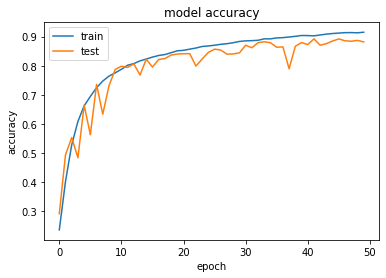

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
## TEST 
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.3702 - accuracy: 0.8817
Test loss: 0.37021103501319885
Test accuracy: 0.8816999793052673


In [16]:
batch_size = 16
num_classes = 10
epochs = 75

In [17]:
## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr,checkpoint_cb],
                            verbose=1)

Epoch 1/75
   4/3125 [..............................] - ETA: 1:08 - loss: 0.3013 - accuracy: 0.8750

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


3125/3125 [==============================] - 47s 15ms/step - loss: 0.3661 - accuracy: 0.8743 - val_loss: 0.4948 - val_accuracy: 0.8436
Epoch 2/75
3125/3125 [==============================] - 48s 15ms/step - loss: 0.3622 - accuracy: 0.8776 - val_loss: 0.4687 - val_accuracy: 0.8538
Epoch 3/75
3125/3125 [==============================] - 48s 15ms/step - loss: 0.3443 - accuracy: 0.8836 - val_loss: 0.4529 - val_accuracy: 0.8621
Epoch 4/75
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3417 - accuracy: 0.8857 - val_loss: 0.4678 - val_accuracy: 0.8615
Epoch 5/75
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3343 - accuracy: 0.8859 - val_loss: 0.4689 - val_accuracy: 0.8488
Epoch 6/75
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3218 - accuracy: 0.8921 - val_loss: 0.3767 - val_accuracy: 0.8800
Epoch 7/75
3125/3125 [==============================] - 47s 15ms/step - loss: 0.3151 - accuracy: 0.8927 - val_loss: 0.3573 - val_accura

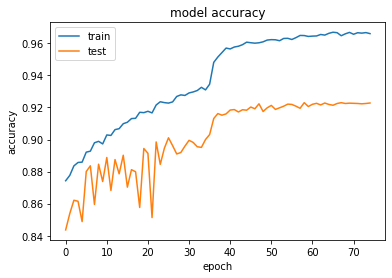

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
## TEST 
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.2790 - accuracy: 0.9228
Test loss: 0.2789708971977234
Test accuracy: 0.9228000044822693


In [20]:
## TEST Mejor Modelo
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/cifar/tmp/tmp_weights"
model.load_weights(checkpoint_path)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.2751 - accuracy: 0.9230
Test loss: 0.27505260705947876
Test accuracy: 0.9229999780654907


In [21]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/cifar/cifar9230/cifar9230_weights")